# Synthetic Difference-in-Differences

In previous chapters, we looked into both Difference-in-Differences and Synthetic control methods for identifying the treatment effect with panel data (data where we have multiple units observed across multiple time periods). It turns out we can merge both approached into a single estimator. This new Synthetic Difference-in-Differences estimation procedure manages to exploit advantages of both methods while also increasing the precision (decreasing the error bars) of the treatment effect estimator.

Synthetic Difference in Difference works on **staggered adoption treatment assignment**. This means we observe multiple units acorss time and, at some point, some units are treated while other units remain untreated. We can vizualize this by a matrix of treatment assigments $D$

$$
D = \begin{bmatrix}
    0 & 0 & 0 & \dots & 0 & 0 \\
    0 & 0 & 0 & \dots & 0 & 0 \\
    \vdots \\
    0 & 0 & 0 & \dots & 1 & 1 \\
    0 & 0 & 0 & \dots & 1 & 1 \\
\end{bmatrix}
$$

To make things more concrete, let's follow along the example of estimating the impact of Proposition 99 in California's Cigarrete Sales. In this case, we only have one treated unit, California, that gets treated (passes Porposition 99) at some point in time (November 1988, to be precise).

$$
D = \begin{bmatrix}
    0 & 0 & 0 & \dots & 0 & 0 \\
    0 & 0 & 0 & \dots & 0 & 0 \\
    \vdots \\
    0 & 0 & 0 & \dots & 0 & 0 \\
    0 & 0 & 0 & \dots & 1 & 1 \\
\end{bmatrix}
$$

Notice that here we are only talking about the case where all treated units get the treatment at the same point in time. In the end, we will discuss how to handle the case where the treatment is gradually rolled out to units, causing them to get it at different points in time. The only thing we require here is that, once a unit is treated, it doesn't roll back to being untreated, which is what the staggered addoption treatment assignment implies.

Back to the simple case, where we have all units treated at the same time, we can simplify the treatment assigment matrix to contain four blocks, each represented by a matrix. The first one (top left) correspond to the control units prior to the treatment period; the second one (top right) corresponds to the control unit after the treatment period; the third block (bottom left) is the treated unit prior to the treatment period and the fourth blok (bottom right) is the treated unit after the treatment period. The treatment indicator zero everywhere exept for the block with the treated units after the treatment period. 

$$
D = \begin{bmatrix}
    \pmb{0} & \pmb{0} \\
    \pmb{0} & \pmb{1} \\
\end{bmatrix}
$$

This assignment matrix will lead to the the folowing outcome matrix. 

$$
Y = \begin{bmatrix}
    \pmb{Y}_{co, pre} & \pmb{Y}_{co, post} \\
    \pmb{Y}_{tr, pre} & \pmb{Y}_{tr, post} \\
\end{bmatrix}
$$

In the our example of estimating the effect of Proposition 99, the outcome $Y$ is cigarrete sales. We use $pre$ and $post$ to represent the perids prior and after the treatment, respectivly, and $co$ and $tr$ to represent the control and treated units respectivly. 

In terms of our data, we will represent it with 5 columns: one representing the units, one representing the time periods, the outcome column and two boolean columns flagin the treated units and the treatment period. 

In [1]:
import numpy as np
import pandas as pd
from toolz import curry
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf
import cvxpy as cp

import warnings
warnings.filterwarnings('ignore')

from matplotlib import style
style.use("ggplot")

In [8]:
data = (pd.read_csv("data/smoking.csv")[["state", "year", "cigsale", "california", "after_treatment"]]
        .rename(columns={"california": "treated"})
        .replace({"state": {3: "california"}}))

data.head()

,state,year,cigsale,treated,after_treatment
0,1,1970,89.800003,False,False
1,1,1971,95.400002,False,False
2,1,1972,101.099998,False,False
3,1,1973,102.900002,False,False
4,1,1974,108.199997,False,False


In [11]:
data.query("state=='california'").query("year.between(1986, 1990)")

,state,year,cigsale,treated,after_treatment
78,california,1986,99.699997,True,False
79,california,1987,97.500000,True,False
80,california,1988,90.099998,True,False
81,california,1989,82.400002,True,True
82,california,1990,77.800003,True,True


In [5]:
# for easier plotting
data_piv = data.pivot("year", "state", "cigsale")
data_piv = data_piv.rename(columns={c: f"state_{c}" for c in data_piv.columns}).rename(columns={"state_3": "california"})

Text(0, 0.5, 'Cigarette Sales')

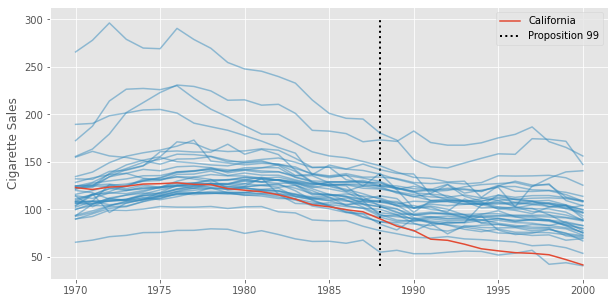

In [3]:
plt.figure(figsize=(10,5))
plt.plot(data_piv.drop(columns=["california"]), color="C1", alpha=0.5)
plt.plot(data_piv["california"], color="C0", label="California")
plt.vlines(x=1988, ymin=40, ymax=300, linestyle=":", lw=2, label="Proposition 99", color="black")
plt.legend()
plt.ylabel("Cigarette Sales")

In [4]:
def calculate_regularization(data, outcome_col, year_col, state_col, treat_col, post_col):
    
    n_treated_post = data.query(post_col).query(treat_col).shape[0]
    
    first_diff_std = (data
                      .query(f"~{post_col}")
                      .query(f"~{treat_col}")
                      .groupby(state_col)
                      [outcome_col]
                      .diff()
                      .std())
    
    return n_treated_post**(1/4) * first_diff_std

    
def fit_unit_weights(data, outcome_col, year_col, state_col, treat_col, post_col):
    
    zeta = calculate_regularization(data, outcome_col, year_col, state_col, treat_col, post_col)
        
    x_pre_control = (data
                     .query(f"~{post_col}")
                     .query(f"~{treat_col}")
                     .pivot(year_col, state_col, outcome_col))
    
    y_pre_treat_mean = (data
                        .query(f"~{post_col}")
                        .query(f"{treat_col}")
                        .groupby(year_col)
                        [outcome_col]
                        .mean())
    
    # add intercept
    T_pre = x_pre_control.shape[0]
    X = np.concatenate([np.ones((T_pre, 1)), x_pre_control.values], axis=1) 
    
    w = cp.Variable(X.shape[1])
    objective = cp.Minimize(cp.sum_squares(X@w - y_pre_treat_mean.values) + T_pre*zeta**2 * cp.sum_squares(w[1:]))
    constraints = [cp.sum(w[1:]) == 1, w[1:] >= 0]
    
    problem = cp.Problem(objective, constraints)
    problem.solve(verbose=False)
    
    return pd.Series(w.value[1:], # remove intercept
                     name="unit_weights",
                     index=x_pre_control.columns)

In [5]:
unit_weights = fit_unit_weights(data,
                                outcome_col="cigsale",
                                year_col="year",
                                state_col="state",
                                treat_col="treated",
                                post_col="after_treatment")

In [6]:
unit_weights.round(3).tail()

state
35   -0.000
36   -0.000
37    0.034
38    0.037
39    0.001
Name: unit_weights, dtype: float64

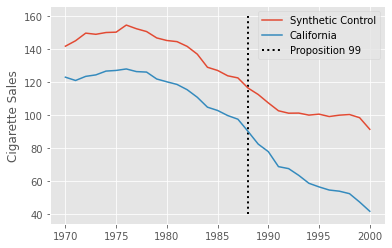

In [7]:
sc = data_piv.drop(columns="california").values @ unit_weights.values

plt.plot(data_piv.index, sc, label="Synthetic Control")
plt.plot(data_piv["california"], label="California")

plt.vlines(x=1988, ymin=40, ymax=160, linestyle=":", lw=2, label="Proposition 99", color="black")
plt.legend()
plt.ylabel("Cigarette Sales");

In [8]:
def fit_time_weights(data, outcome_col, year_col, state_col, treat_col, post_col):
        
        control = data.query(f"~{treat_col}")
        
        X_pre = (control
                 .query(f"~{post_col}")
                 .pivot(state_col, year_col, outcome_col))
        
        y_post_mean = (control
                       .query(f"{post_col}")
                       .groupby(state_col)
                       [outcome_col]
                       .mean()
                       .values)
        
        X = np.concatenate([np.ones((X_pre.shape[0], 1)), X_pre.values], axis=1) # add intercept

        w = cp.Variable(X.shape[1])
        objective = cp.Minimize(cp.sum_squares(X@w - y_post_mean))
        constraints = [cp.sum(w[1:]) == 1, w[1:] >= 0]
        
        problem = cp.Problem(objective, constraints)
        problem.solve(verbose=False)
        
        return pd.Series(w.value[1:], # remove intercept
                     name="time_weights",
                     index=X_pre.columns)

In [9]:
time_weights = fit_time_weights(data,
                                outcome_col="cigsale",
                                year_col="year",
                                state_col="state",
                                treat_col="treated",
                                post_col="after_treatment")

time_weights.round(3).tail()

year
1984   -0.000
1985   -0.000
1986    0.366
1987    0.206
1988    0.427
Name: time_weights, dtype: float64

In [10]:
def join_weights(data, unit_w, time_w, year_col, state_col, treat_col, post_col):

    return (
        data
        .set_index([year_col, state_col])
        .join(time_w)
        .join(unit_w)
        .reset_index()
        .fillna({time_w.name: data[post_col].mean(),
                 unit_w.name: data[treat_col].mean()})
        .assign(**{"weights": lambda d: d[time_w.name]*d[unit_w.name]})
        .astype({treat_col:int, post_col:int}))

In [11]:
did_data = join_weights(data, unit_weights, time_weights,
                        year_col="year",
                        state_col="state",
                        treat_col="treated",
                        post_col="after_treatment")

did_data.head()

,year,state,cigsale,treated,after_treatment,time_weights,unit_weights,weights
0,1970,1,89.800003,0,0,-4.600041e-14,-1.360835e-16,6.259896e-30
1,1971,1,95.400002,0,0,-4.582326e-14,-1.360835e-16,6.235789e-30
2,1972,1,101.099998,0,0,-5.274204e-14,-1.360835e-16,7.177320e-30
3,1973,1,102.900002,0,0,-5.766365e-14,-1.360835e-16,7.847071e-30
4,1974,1,108.199997,0,0,-5.617991e-14,-1.360835e-16,7.645158e-30


In [12]:
did_model = smf.wls("cigsale ~ after_treatment*treated",
                    data=did_data,
                    weights=did_data["weights"]+1e-10).fit()

did_model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,120.4060,1.965,61.278,0.000,116.551,124.261
after_treatment,-19.1905,2.166,-8.859,0.000,-23.440,-14.941
treated,-25.2601,12.427,-2.033,0.042,-49.641,-0.879
after_treatment:treated,-15.6054,13.700,-1.139,0.255,-42.483,11.272


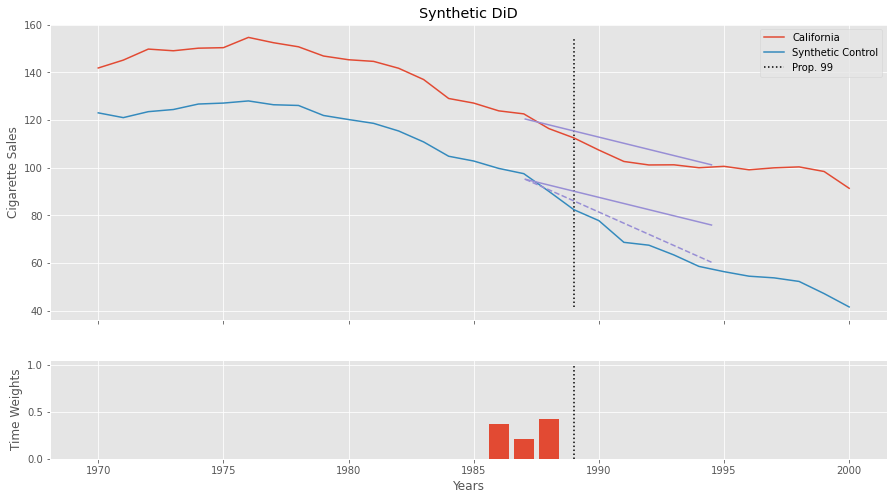

In [13]:
avg_pre_period = (time_weights * time_weights.index).sum()
avg_post_period = 1989 + (2000 - 1989) / 2

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

ax1.plot(data_piv.index, sc, label="California")
ax1.plot(data_piv.index, data_piv["california"], label="Synthetic Control")
ax1.vlines(1989, data_piv["california"].min(), sc.max(), color="black", ls="dotted", label="Prop. 99")

pre_sc = did_model.params["Intercept"]
post_sc = pre_sc + did_model.params["after_treatment"]
pre_treat = pre_sc + did_model.params["treated"]
post_treat = post_sc + did_model.params["treated"] + did_model.params["after_treatment:treated"]

sc_did_y0 = pre_treat + (post_sc - pre_sc)

ax1.plot([avg_pre_period, avg_post_period], [pre_sc, post_sc], color="C2")
ax1.plot([avg_pre_period, avg_post_period], [pre_treat, post_treat], color="C2", ls="dashed")
ax1.plot([avg_pre_period, avg_post_period], [pre_treat, sc_did_y0], color="C2")
ax1.legend()
ax1.set_title("Synthetic DiD")
ax1.set_ylabel("Cigarette Sales")

ax2.bar(time_weights.index, time_weights)
ax2.vlines(1989, 0, 1, color="black", ls="dotted")
ax2.set_ylabel("Time Weights")
ax2.set_xlabel("Years");

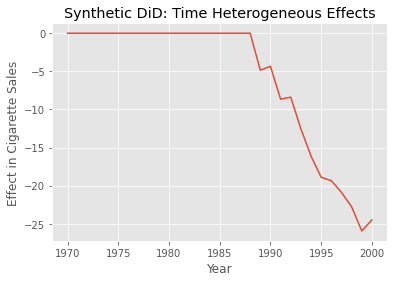

In [14]:
model = smf.wls("cigsale ~ treated:after_treatment:C(year) + C(state) + C(year)",
        data=did_data,
        weights=did_data["weights"] + 1e-10,
       ).fit()

effect = pd.Series(model.params[model.params.index.str.contains("treated")].values,
                   index=sorted(did_data["year"].unique()))
effect.plot()
plt.title("Synthetic DiD: Time Heterogeneous Effects")
plt.ylabel("Effect in Cigarette Sales")
plt.xlabel("Year");

In [15]:
def synthetic_diff_in_diff(data, outcome_col, year_col, state_col, treat_col, post_col, formula=None):
    
    unit_weights = fit_unit_weights(data,
                                    outcome_col=outcome_col,
                                    year_col=year_col,
                                    state_col=state_col,
                                    treat_col=treat_col,
                                    post_col=post_col)
    
    time_weights = fit_time_weights(data,
                                    outcome_col=outcome_col,
                                    year_col=year_col,
                                    state_col=state_col,
                                    treat_col=treat_col,
                                    post_col=post_col)

    did_data = join_weights(data, unit_weights, time_weights,
                            year_col=year_col,
                            state_col=state_col,
                            treat_col=treat_col,
                            post_col=post_col)

    formula = f"{outcome_col} ~ {post_col}*{treat_col}" if formula is None else formula
    did_model = smf.wls(formula, data=did_data, weights=did_data["weights"]+1e-10).fit()
    params = did_model.params
    
    return pd.Series(params[params.index.str.contains(f"{post_col}") & params.index.str.contains(f"{treat_col}")])
    

In [16]:
effect = synthetic_diff_in_diff(data, 
                                outcome_col="cigsale",
                                year_col="year",
                                state_col="state",
                                treat_col="treated",
                                post_col="after_treatment")

In [17]:
effect

after_treatment:treated   -15.605399
dtype: float64

In [18]:
effects_by_year = synthetic_diff_in_diff(data, 
                                         outcome_col="cigsale",
                                         year_col="year",
                                         state_col="state",
                                         treat_col="treated",
                                         post_col="after_treatment",
                                         formula="cigsale ~ treated:after_treatment:C(year) + C(state) + C(year)")

In [19]:
effects_by_year.round(3)

treated:after_treatment:C(year)[1970]     0.000
treated:after_treatment:C(year)[1971]    -0.000
treated:after_treatment:C(year)[1972]    -0.000
treated:after_treatment:C(year)[1973]     0.000
treated:after_treatment:C(year)[1974]    -0.000
treated:after_treatment:C(year)[1975]    -0.000
treated:after_treatment:C(year)[1976]    -0.000
treated:after_treatment:C(year)[1977]     0.000
treated:after_treatment:C(year)[1978]    -0.000
treated:after_treatment:C(year)[1979]     0.000
treated:after_treatment:C(year)[1980]    -0.000
treated:after_treatment:C(year)[1981]    -0.000
treated:after_treatment:C(year)[1982]     0.000
treated:after_treatment:C(year)[1983]     0.000
treated:after_treatment:C(year)[1984]     0.000
treated:after_treatment:C(year)[1985]     0.000
treated:after_treatment:C(year)[1986]     0.000
treated:after_treatment:C(year)[1987]     0.000
treated:after_treatment:C(year)[1988]     0.000
treated:after_treatment:C(year)[1989]    -4.844
treated:after_treatment:C(year)[1990]   

## Placebo Variance Estimation

In [20]:
def make_random_placebo(data, state_col, treat_col):
    control = data.query(f"~{treat_col}")
    states = control[state_col].unique()
    placebo_state = np.random.choice(states, replace=False)
    
    return control.assign(**{treat_col: control[state_col] == placebo_state})

In [21]:
np.random.seed(1)
placebo_data = make_random_placebo(data, state_col="state", treat_col="treated")
placebo_data.tail()

,state,year,cigsale,treated,after_treatment
1204,39,1996,110.300003,False,True
1205,39,1997,108.800003,False,True
1206,39,1998,102.900002,False,True
1207,39,1999,104.800003,False,True
1208,39,2000,90.500000,False,True


In [22]:
def estimate_se(data, outcome_col, year_col, state_col, treat_col, post_col, bootstrap_rounds=400, formula=None, seed=0):
    np.random.seed(seed=seed)
    effects = [synthetic_diff_in_diff(make_random_placebo(data, state_col=state_col, treat_col=treat_col), 
                                      outcome_col=outcome_col,
                                      year_col=year_col,
                                      state_col=state_col,
                                      treat_col=treat_col,
                                      post_col=post_col,
                                      formula=formula,)
              for _ in range(bootstrap_rounds)]
    
    return np.std(effects, axis=0)


In [23]:
effect = synthetic_diff_in_diff(data,
                                outcome_col="cigsale",
                                year_col="year",
                                state_col="state",
                                treat_col="treated",
                                post_col="after_treatment")


se = estimate_se(data,
                 outcome_col="cigsale",
                 year_col="year",
                 state_col="state",
                 treat_col="treated",
                 post_col="after_treatment")

In [24]:
print(f"Effect: {effect['after_treatment:treated']}")
print(f"Standard Error: {se[0]}")

Effect: -15.605398734600275
Standard Error: 8.927635522088968


In [25]:
print(f"90% CI: ({effect['after_treatment:treated']-1.65*se[0]}, {effect['after_treatment:treated']+1.65*se[0]})")

90% CI: (-30.335997346047073, -0.874800123153479)


In [26]:
effect = synthetic_diff_in_diff(data,
                                outcome_col="cigsale",
                                year_col="year",
                                state_col="state",
                                treat_col="treated",
                                post_col="after_treatment",
                                formula="cigsale ~ treated:after_treatment:C(year) + C(state) + C(year)")


se = estimate_se(data,
                 outcome_col="cigsale",
                 year_col="year",
                 state_col="state",
                 treat_col="treated",
                 post_col="after_treatment",
                 formula="cigsale ~ treated:after_treatment:C(year) + C(state) + C(year)")

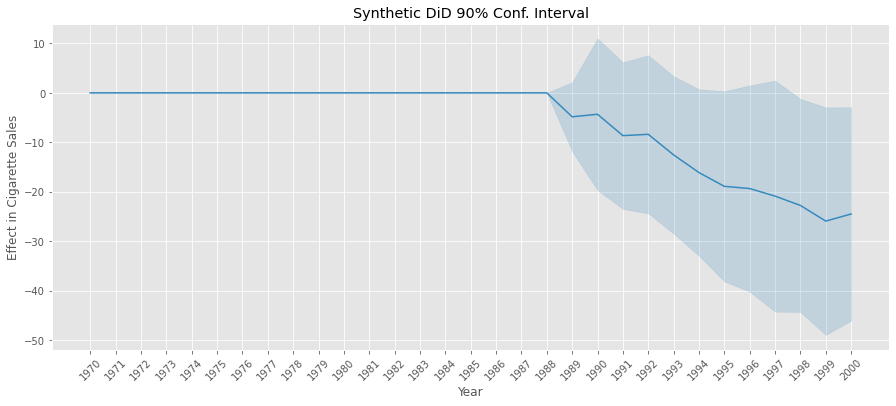

In [27]:
plt.figure(figsize=(15,6))
years = effect.index.astype(str).str.split(r"\[|\]").str[-2]

plt.plot(years, effect, color="C1")
plt.fill_between(years, effect-1.65*se, effect+1.65*se, alpha=0.2,  color="C1")

plt.ylabel("Effect in Cigarette Sales")
plt.xlabel("Year")
plt.title("Synthetic DiD 90% Conf. Interval")
plt.xticks(rotation=45);

In [28]:
def synthetic_control(data, outcome_col, year_col, state_col, treat_col, post_col):
    
    x_pre_control = (data
                     .query(f"~{treat_col}")
                     .query(f"~{post_col}")
                     .pivot(year_col, state_col, outcome_col)
                     .values)
    
    y_pre_treat_mean = (data
                        .query(f"~{post_col}")
                        .query(f"{treat_col}")
                        .groupby(year_col)
                        [outcome_col]
                        .mean())
    
    w = cp.Variable(x_pre_control.shape[1])
    objective = cp.Minimize(cp.sum_squares(x_pre_control@w - y_pre_treat_mean.values))
    constraints = [cp.sum(w) == 1, w >= 0]
    
    problem = cp.Problem(objective, constraints)
    problem.solve(verbose=False)
    
    sc = (data
          .query(f"~{treat_col}")
          .pivot(year_col, state_col, outcome_col)
          .values) @ w.value
    
    y1 = data.query(f"{treat_col}").query(f"{post_col}")[outcome_col]
    att = np.mean(y1 - sc[-len(y1):])
    
    return att


def estimate_se_sc(data, outcome_col, year_col, state_col, treat_col, post_col, bootstrap_rounds=400, seed=0):
    np.random.seed(seed=seed)
    effects = [synthetic_control(make_random_placebo(data, state_col=state_col, treat_col=treat_col), 
                                 outcome_col=outcome_col,
                                 year_col=year_col,
                                 state_col=state_col,
                                 treat_col=treat_col,
                                 post_col=post_col)
              for _ in range(bootstrap_rounds)]
    
    return np.std(effects, axis=0)


effect_sc = synthetic_control(data,
                              outcome_col="cigsale",
                              year_col="year",
                              state_col="state",
                              treat_col="treated",
                              post_col="after_treatment")


se_sc = estimate_se_sc(data,
                       outcome_col="cigsale",
                       year_col="year",
                       state_col="state",
                       treat_col="treated",
                       post_col="after_treatment")

In [29]:
print(f"Effect: {effect_sc}")
print(f"Standard Error: {se_sc}")

print(f"90% CI: ({effect_sc-1.65*se_sc}, {effect_sc+1.65*se_sc})")

Effect: -19.513629763998537
Standard Error: 10.398847371533353
90% CI: (-36.67172792702857, -2.3555316009685043)
